# AVI-DYS Time Series Classification Demo

### This notebook begins with the output of the postprocessing pipeline. Then it performs time series classification on the AVI-DYS dataset using the HIVE-COTE 2.0 algorithm.

### Define Functions

The script defines the following functions:

* `evaluate_model()`: Performs 5-fold cross-validation on the data and returns the predicted labels and actual labels.
* `generate_confusion_matrix()`: Plots the confusion matrix for a given set of predicted and actual labels.
* `plot_confusion_matrix()`: Plots the confusion matrices for the predicted and actual labels for all four outcome measures.
* `tsc()`: This function trains an instance of HIVE-COTE 2.0, predicts the labels, and plots the confusion matrices and a classification report.

### Read Data

The script then reads the data from the CSV files and creates a 3D NumPy array.

### Train Model

The script then trains an instance of the HIVE-COTE 2.0 algorithm on the data.

### Predict Labels

The script then predicts the labels for all four outcome measures.

### Plot Confusion Matrices

The script finally plots the confusion matrices for the predicted and actual labels for all four outcome measures.

## Import Libraries

In [1]:
import os
import numpy as np
np.set_printoptions(precision=2)
import pandas as pd
import itertools
from sklearn.model_selection import StratifiedKFold
from sktime.classification.hybrid import HIVECOTEV2
from sklearn.metrics import confusion_matrix
#from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

### Set User specific parameters (change the demo_path to location of the demo folder on your computer)

In [2]:
demo_folder = './'

IDs = ['001', '003', '004', '005', '115', '116', '117', '118', '120', '121',
       '122', '123', '125', '126', '127', '128', '129', '130', '131', '132',
       '133', '135', '138', '151', '152', '301', '303', '304', '305', '306',
       '307', '308', '309']

In [3]:
data_path = os.path.join(demo_folder,'Data','0-baseline')
save_path = os.path.join(demo_folder,'Results','TSC')

In [6]:
import pandas as pd

y = pd.read_csv(os.path.join(demo_folder,'Data', 'Y.csv'))

y['Dystonia-Duration'] = y['Dystonia-Duration'].replace(2, 1)
y['Dystonia-Duration'] = y['Dystonia-Duration'].replace(3, 1)
y['Dystonia-Duration'] = y['Dystonia-Duration'].replace(4, 1)

y['Dystonia-Amplitude'] = y['Dystonia-Amplitude'].replace(2, 1)
y['Dystonia-Amplitude'] = y['Dystonia-Amplitude'].replace(3, 1)
y['Dystonia-Amplitude'] = y['Dystonia-Amplitude'].replace(4, 1)

y['Choreoathetosis-Duration'] = y['Choreoathetosis-Duration'].replace(4, 1)
y['Choreoathetosis-Duration'] = y['Choreoathetosis-Duration'].replace(3, 1)
y['Choreoathetosis-Duration'] = y['Choreoathetosis-Duration'].replace(2, 1)

y['Choreoathetosis-Amplitude'] = y['Choreoathetosis-Amplitude'].replace(2, 1)
y['Choreoathetosis-Amplitude'] = y['Choreoathetosis-Amplitude'].replace(3, 1)
y['Choreoathetosis-Amplitude'] = y['Choreoathetosis-Amplitude'].replace(4, 1)

y.head()

,Unnamed: 0,ID,Side Code,Dystonia-Duration,Dystonia-Amplitude,Choreoathetosis-Duration,Choreoathetosis-Amplitude
0,0,1,11,0,0,0,0
1,1,1,12,0,0,0,0
2,2,3,11,0,0,0,0
3,3,3,12,0,0,0,0
4,4,4,11,0,0,0,0


In [8]:
# save y

y.to_csv(os.path.join(demo_folder,'Data', 'Y.csv'), index=False)

# Functions

In [9]:
def evaluate_model(data_x, data_y, print_folds):

    k_fold = StratifiedKFold(n_splits=5)

    # Print the folds
    if print_folds == True:
        for i, (train_index, test_index) in enumerate(k_fold.split(data_x, data_y)):
            print(f"Fold {i}:")
            print(f"  Train: index={train_index}")
            print(f"  Test:  index={test_index}")

    predicted_targets = np.array([])
    actual_targets = np.array([])

    for train_ix, test_ix in k_fold.split(data_x,data_y):
        train_x, train_y, test_x, test_y = data_x[train_ix], data_y[train_ix], data_x[test_ix], data_y[test_ix]

        # Fit the classifier
        classifier = hc2.fit(train_x, train_y)

        # Predict the labels of the test set samples
        predicted_labels = classifier.predict(test_x)

        predicted_targets = np.append(predicted_targets, predicted_labels)
        actual_targets = np.append(actual_targets, test_y)

    return predicted_targets, actual_targets

In [10]:
def generate_confusion_matrix(cnf_matrix, classes, normalize=False, title='Confusion matrix'):
    
    if normalize:
        cnf_matrix = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cnf_matrix, interpolation='nearest', cmap=plt.get_cmap('Blues'))
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cnf_matrix.max() / 2.

    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, format(cnf_matrix[i, j], fmt), horizontalalignment="center",
                 color="white" if cnf_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    return cnf_matrix

In [11]:
def plot_confusion_matrix(predicted_labels_list, y_test_list):
    cnf_matrix = confusion_matrix(y_test_list, predicted_labels_list)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    generate_confusion_matrix(cnf_matrix, classes=class_names, title=f'{Measure}')
    
    # Save the confusion matrix
    png = str(os.path.join(save_path,f"confusion-matrix-{Measure}.png"))
    svg = str(os.path.join(save_path,f"confusion-matrix-{Measure}.svg"))
    plt.savefig(png,bbox_inches='tight',dpi=400)
    plt.savefig(svg,bbox_inches='tight')
    plt.show()

    # Plot normalized confusion matrix
    plt.figure()
    generate_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title=f'{Measure}')
    png = str(os.path.join(save_path,f"normalized-confusion-matrix-{Measure}.png"))
    svg = str(os.path.join(save_path,f"normalized-confusion-matrix-{Measure}.svg"))
    plt.savefig(png,bbox_inches='tight',dpi=400)
    plt.savefig(svg,bbox_inches='tight')
    plt.show()

In [12]:
def tsc(Measure):

    """Train an instance of HIVE-COTE 2.0, predict the labels, print confusion matrices and a classification report
    """

    # Get the relevant column from the outcome measures
    y = Y[Measure].astype(str).to_numpy()

    # Fit the classifier on all folds
    predicted_target, actual_target = evaluate_model(X, y, print_folds=False)

    # Save the y train-test split and predictions
    df_y_train = pd.DataFrame({'DIS-Score': y, 'split': 'y_train'})
    df_y_pred = pd.DataFrame({'DIS-Score': predicted_target, 'split': 'y_pred'})
    df = pd.concat([df_y_train, df_y_pred], ignore_index=True)
    df.to_csv(os.path.join(save_path,f'y-{Measure}.csv'))

    # Plot thte confusion matrices
    plot_confusion_matrix(predicted_target, actual_target)

    # Print the classification report
    print(classification_report(actual_target, predicted_target))

## Read in the True Labels

In [13]:
Y = pd.read_csv(os.path.join(demo_folder,'Data','Y.csv'))

## Create the 3D numpy array

Initialize an output DataFrame for the Data (X)

In [14]:
# Make a list of columns based on the movement and skeleton data
cols = ['HLX_x', 'HLX_y', 'D1M_x', 'D1M_y', 'D3M_x', 'D3M_y', 'ANK_x',
       'ANK_y', 'KNE_x', 'KNE_y', 'KNE_ANK_length',
       'KNE_ANK_orientation', 'ANK_D3M_length', 'ANK_D3M_orientation',
       'ANK_D1M_length', 'ANK_D1M_orientation', 'D1M_HLX_length',
       'D1M_HLX_orientation']

# Create an empty dataframe
df = pd.DataFrame(columns=cols)

Enter each feature into the DataFrame as a single cell

In [15]:
for i in IDs:
   
   # Read in the 
    right_data = pd.read_csv(os.path.join(data_path,f'{i}-right-data.csv'))
    left_data = pd.read_csv(os.path.join(data_path,f'{i}-left-data.csv'))    
    
    right_flat = pd.DataFrame(index=[f'{i}-right'])
    for c in right_data.columns:
        right_flat[c] = [right_data[c].to_numpy()]  

    left_flat = pd.DataFrame(index=[f'{i}-left'])
    for c in left_data.columns:
        left_flat[c] = [left_data[c].to_numpy()]    
    
    df = pd.concat([df, right_flat, left_flat,])

Convert the DataFrame into a 3D numpy array (observations, features, time points)

In [16]:
# Extract the values from the DataFrame
data = df.values

# Create an empty 3D NumPy array
num_rows, num_columns = df.shape
num_elements = df.iloc[0, 0].shape[0]
X = np.empty((num_rows, num_columns, num_elements))

# Populate the 3D array with the values from the DataFrame
for i in range(num_rows):
    for j in range(num_columns):
        X[i, j] = data[i, j]

## HIVE-COTE 2.0

#### Predict the Dystonia Duration Scores

In [17]:
class_names = ['0','1']

The arguement for the time contract (time_limit_in_minutes) is set to .1, which is very short and will result in relatively poor performance. Users may increase the time contract (~2 should result in reasonable run times on a laptop). Our study was run without a time limit, which may result in a total runtime measured in days on laptop. Caveat emptor.

In [18]:
# Create the classifier
hc2 =HIVECOTEV2(
    stc_params=None,
    drcif_params=None,
    arsenal_params=None,
    tde_params=None,
    time_limit_in_minutes=.1,
    save_component_probas=False,
    verbose=1,
    random_state=42,
)

#### Predict the Dystonia Duration Scores

STC  06:24:31 13/03/2025
STC train estimate  06:24:31 13/03/2025
STC weight = 0.42558252512166944


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sktime/transformations/panel/catch22.py:350: FutureWarning: In Catch22._transform_single_feature, the argument case_id is deprecated and will be removed in the future.
  warn(


DrCIF  06:24:35 13/03/2025
DrCIF train estimate  06:24:35 13/03/2025
DrCIF weight = 0.04537656244529254
Arsenal  06:24:38 13/03/2025
Arsenal train estimate  06:24:39 13/03/2025
Arsenal weight = 0.03203888169181751
TDE  06:24:41 13/03/2025
TDE train estimate  06:24:41 13/03/2025
TDE weight = 0.11078262315745244


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sktime/transformations/panel/catch22.py:350: FutureWarning: In Catch22._transform_single_feature, the argument case_id is deprecated and will be removed in the future.
  warn(


STC  06:24:46 13/03/2025
STC train estimate  06:24:46 13/03/2025
STC weight = 0.5674503240043288


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sktime/transformations/panel/catch22.py:350: FutureWarning: In Catch22._transform_single_feature, the argument case_id is deprecated and will be removed in the future.
  warn(


DrCIF  06:24:50 13/03/2025
DrCIF train estimate  06:24:50 13/03/2025
DrCIF weight = 0.04950585395237629
Arsenal  06:24:53 13/03/2025
Arsenal train estimate  06:24:54 13/03/2025
Arsenal weight = 0.04950585395237629
TDE  06:24:55 13/03/2025
TDE train estimate  06:24:55 13/03/2025
TDE weight = 0.0778984196273966


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sktime/transformations/panel/catch22.py:350: FutureWarning: In Catch22._transform_single_feature, the argument case_id is deprecated and will be removed in the future.
  warn(


STC  06:25:00 13/03/2025
STC train estimate  06:25:01 13/03/2025
STC weight = 0.5674503240043288


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sktime/transformations/panel/catch22.py:350: FutureWarning: In Catch22._transform_single_feature, the argument case_id is deprecated and will be removed in the future.
  warn(


DrCIF  06:25:04 13/03/2025
DrCIF train estimate  06:25:04 13/03/2025
DrCIF weight = 0.04204762675431321
Arsenal  06:25:08 13/03/2025
Arsenal train estimate  06:25:08 13/03/2025
Arsenal weight = 0.03546564525027055
TDE  06:25:10 13/03/2025
TDE train estimate  06:25:10 13/03/2025
TDE weight = 0.16936052440909494


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sktime/transformations/panel/catch22.py:350: FutureWarning: In Catch22._transform_single_feature, the argument case_id is deprecated and will be removed in the future.
  warn(


STC  06:25:15 13/03/2025
STC train estimate  06:25:15 13/03/2025
STC weight = 0.4750148945292436


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sktime/transformations/panel/catch22.py:350: FutureWarning: In Catch22._transform_single_feature, the argument case_id is deprecated and will be removed in the future.
  warn(


DrCIF  06:25:18 13/03/2025
DrCIF train estimate  06:25:18 13/03/2025
DrCIF weight = 0.03546564525027055
Arsenal  06:25:22 13/03/2025
Arsenal train estimate  06:25:22 13/03/2025
Arsenal weight = 0.024647546835230964
TDE  06:25:24 13/03/2025
TDE train estimate  06:25:24 13/03/2025
TDE weight = 0.1328912648037553
STC  06:25:29 13/03/2025
STC train estimate  06:25:29 13/03/2025
STC weight = 0.4332816972754894


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sktime/transformations/panel/catch22.py:350: FutureWarning: In Catch22._transform_single_feature, the argument case_id is deprecated and will be removed in the future.
  warn(


DrCIF  06:25:32 13/03/2025
DrCIF train estimate  06:25:32 13/03/2025
DrCIF weight = 0.01651623012589473
Arsenal  06:25:36 13/03/2025
Arsenal train estimate  06:25:36 13/03/2025
Arsenal weight = 0.024647546835230964
TDE  06:25:38 13/03/2025
TDE train estimate  06:25:38 13/03/2025
TDE weight = 0.11704242111475839
Confusion matrix, without normalization


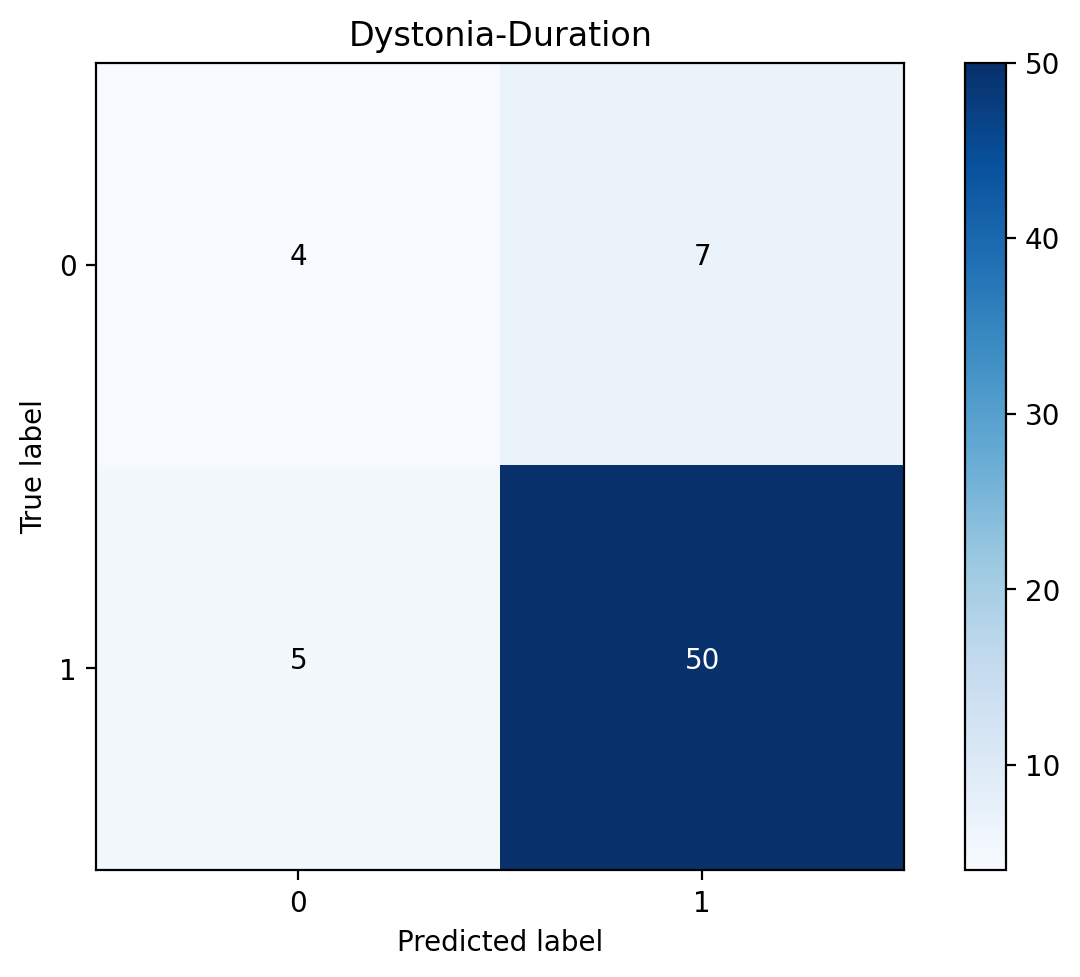

Normalized confusion matrix


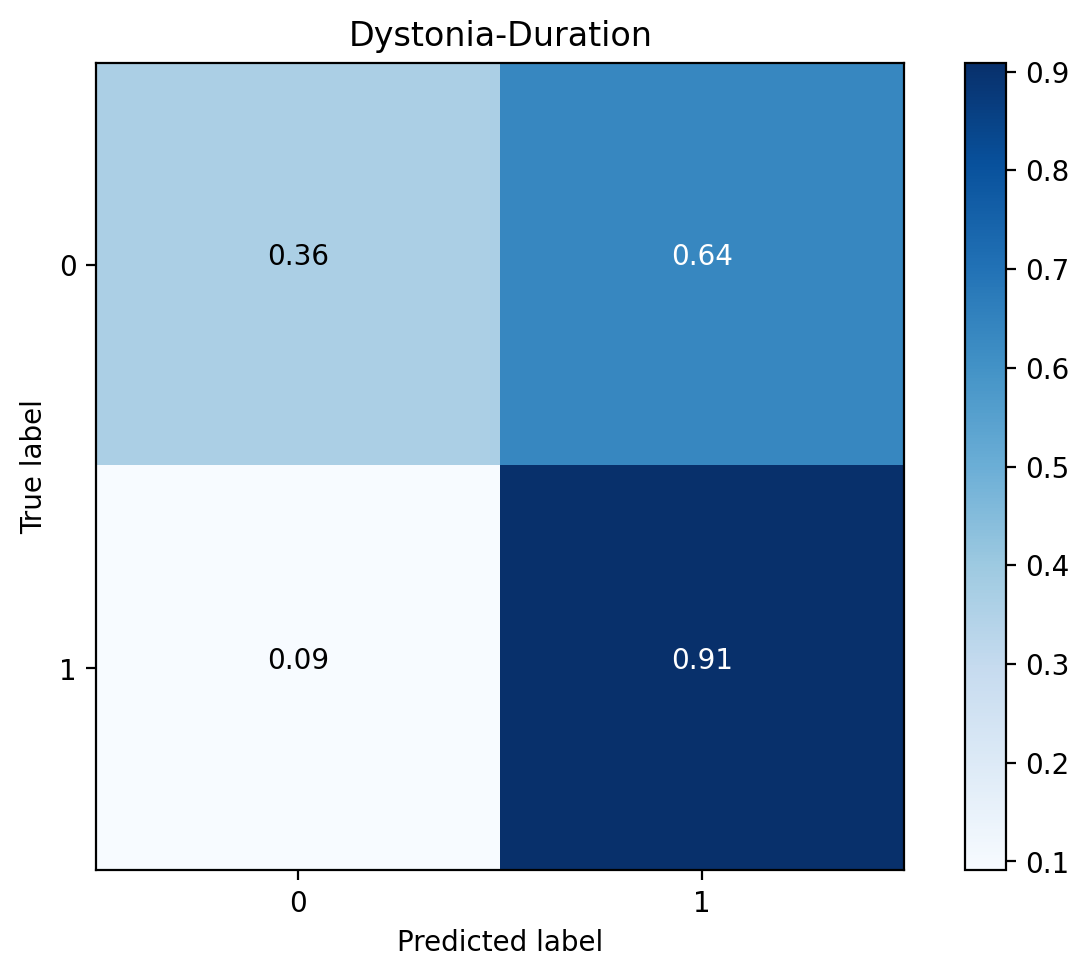

              precision    recall  f1-score   support

           0       0.44      0.36      0.40        11
           1       0.88      0.91      0.89        55

    accuracy                           0.82        66
   macro avg       0.66      0.64      0.65        66
weighted avg       0.81      0.82      0.81        66



In [19]:
Measure = 'Dystonia-Duration'

tsc(Measure)

#### Predict the Choreoathetosis Duration Scores

STC  06:26:56 13/03/2025
STC train estimate  06:26:56 13/03/2025
STC weight = 0.20523848626623725


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sktime/transformations/panel/catch22.py:350: FutureWarning: In Catch22._transform_single_feature, the argument case_id is deprecated and will be removed in the future.
  warn(


DrCIF  06:27:00 13/03/2025
DrCIF train estimate  06:27:00 13/03/2025
DrCIF weight = 0.03203888169181751
Arsenal  06:27:03 13/03/2025
Arsenal train estimate  06:27:04 13/03/2025
Arsenal weight = 0.02659890782010434
TDE  06:27:05 13/03/2025
TDE train estimate  06:27:05 13/03/2025
TDE weight = 0.14341234550610976


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sktime/transformations/panel/catch22.py:350: FutureWarning: In Catch22._transform_single_feature, the argument case_id is deprecated and will be removed in the future.
  warn(


STC  06:27:10 13/03/2025
STC train estimate  06:27:10 13/03/2025
STC weight = 0.26425968201431566


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sktime/transformations/panel/catch22.py:350: FutureWarning: In Catch22._transform_single_feature, the argument case_id is deprecated and will be removed in the future.
  warn(


DrCIF  06:27:14 13/03/2025
DrCIF train estimate  06:27:14 13/03/2025
DrCIF weight = 0.020277597778893333
Arsenal  06:27:18 13/03/2025
Arsenal train estimate  06:27:18 13/03/2025
Arsenal weight = 0.029688430908077726
TDE  06:27:20 13/03/2025
TDE train estimate  06:27:20 13/03/2025
TDE weight = 0.029688430908077726


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sktime/transformations/panel/catch22.py:350: FutureWarning: In Catch22._transform_single_feature, the argument case_id is deprecated and will be removed in the future.
  warn(


STC  06:27:25 13/03/2025
STC train estimate  06:27:25 13/03/2025
STC weight = 0.26425968201431566


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sktime/transformations/panel/catch22.py:350: FutureWarning: In Catch22._transform_single_feature, the argument case_id is deprecated and will be removed in the future.
  warn(


DrCIF  06:27:28 13/03/2025
DrCIF train estimate  06:27:28 13/03/2025
DrCIF weight = 0.04204762675431321
Arsenal  06:27:32 13/03/2025
Arsenal train estimate  06:27:32 13/03/2025
Arsenal weight = 0.04204762675431321
TDE  06:27:34 13/03/2025
TDE train estimate  06:27:34 13/03/2025
TDE weight = 0.11704242111475839


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sktime/transformations/panel/catch22.py:350: FutureWarning: In Catch22._transform_single_feature, the argument case_id is deprecated and will be removed in the future.
  warn(


STC  06:27:39 13/03/2025
STC train estimate  06:27:39 13/03/2025
STC weight = 0.21286611044371054


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sktime/transformations/panel/catch22.py:350: FutureWarning: In Catch22._transform_single_feature, the argument case_id is deprecated and will be removed in the future.
  warn(


DrCIF  06:27:43 13/03/2025
DrCIF train estimate  06:27:43 13/03/2025
DrCIF weight = 0.05791484701629723
Arsenal  06:27:46 13/03/2025
Arsenal train estimate  06:27:47 13/03/2025
Arsenal weight = 0.05791484701629723
TDE  06:27:48 13/03/2025
TDE train estimate  06:27:48 13/03/2025
TDE weight = 0.16936052440909494


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sktime/transformations/panel/catch22.py:350: FutureWarning: In Catch22._transform_single_feature, the argument case_id is deprecated and will be removed in the future.
  warn(


STC  06:27:53 13/03/2025
STC train estimate  06:27:53 13/03/2025
STC weight = 0.21286611044371054


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sktime/transformations/panel/catch22.py:350: FutureWarning: In Catch22._transform_single_feature, the argument case_id is deprecated and will be removed in the future.
  warn(


DrCIF  06:27:56 13/03/2025
DrCIF train estimate  06:27:56 13/03/2025
DrCIF weight = 0.03546564525027055
Arsenal  06:28:00 13/03/2025
Arsenal train estimate  06:28:01 13/03/2025
Arsenal weight = 0.06735216775758031
TDE  06:28:02 13/03/2025
TDE train estimate  06:28:02 13/03/2025
TDE weight = 0.11704242111475839


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sktime/transformations/panel/catch22.py:350: FutureWarning: In Catch22._transform_single_feature, the argument case_id is deprecated and will be removed in the future.
  warn(


Confusion matrix, without normalization


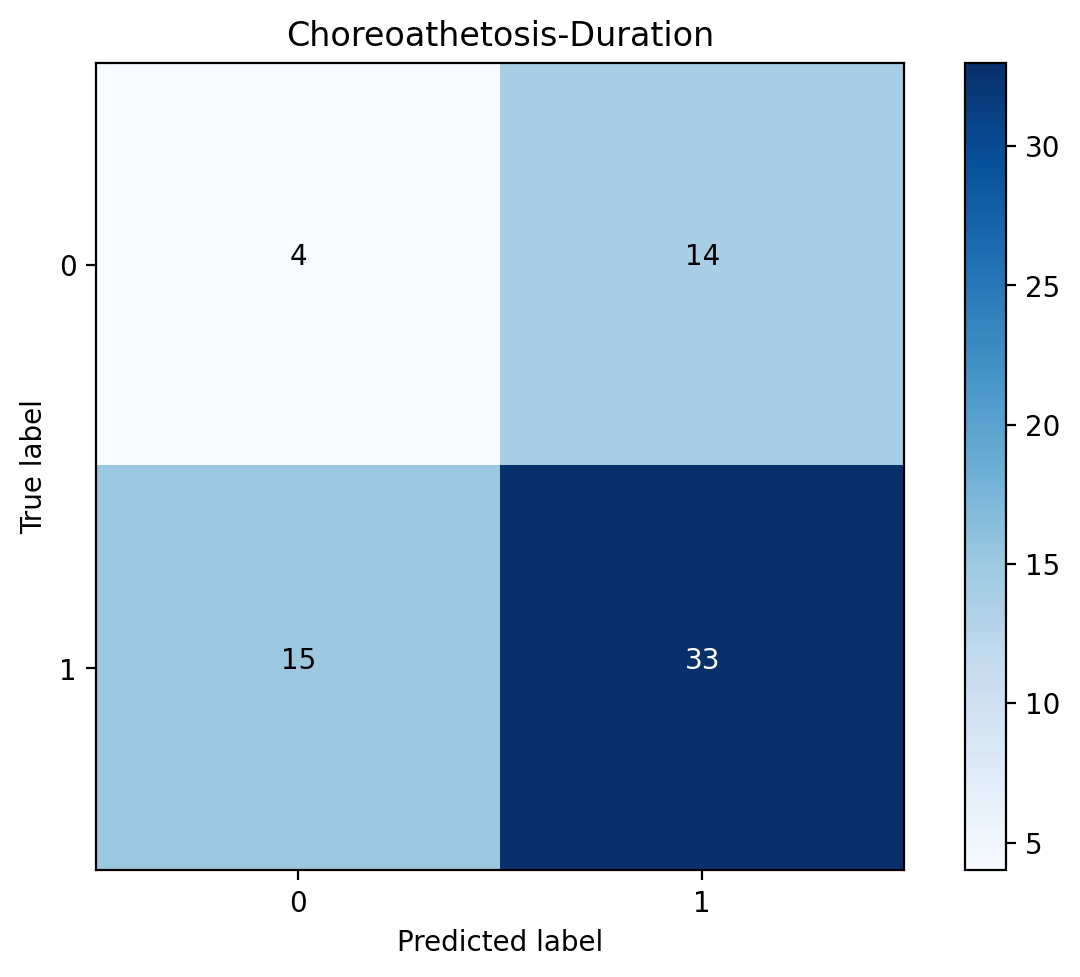

Normalized confusion matrix


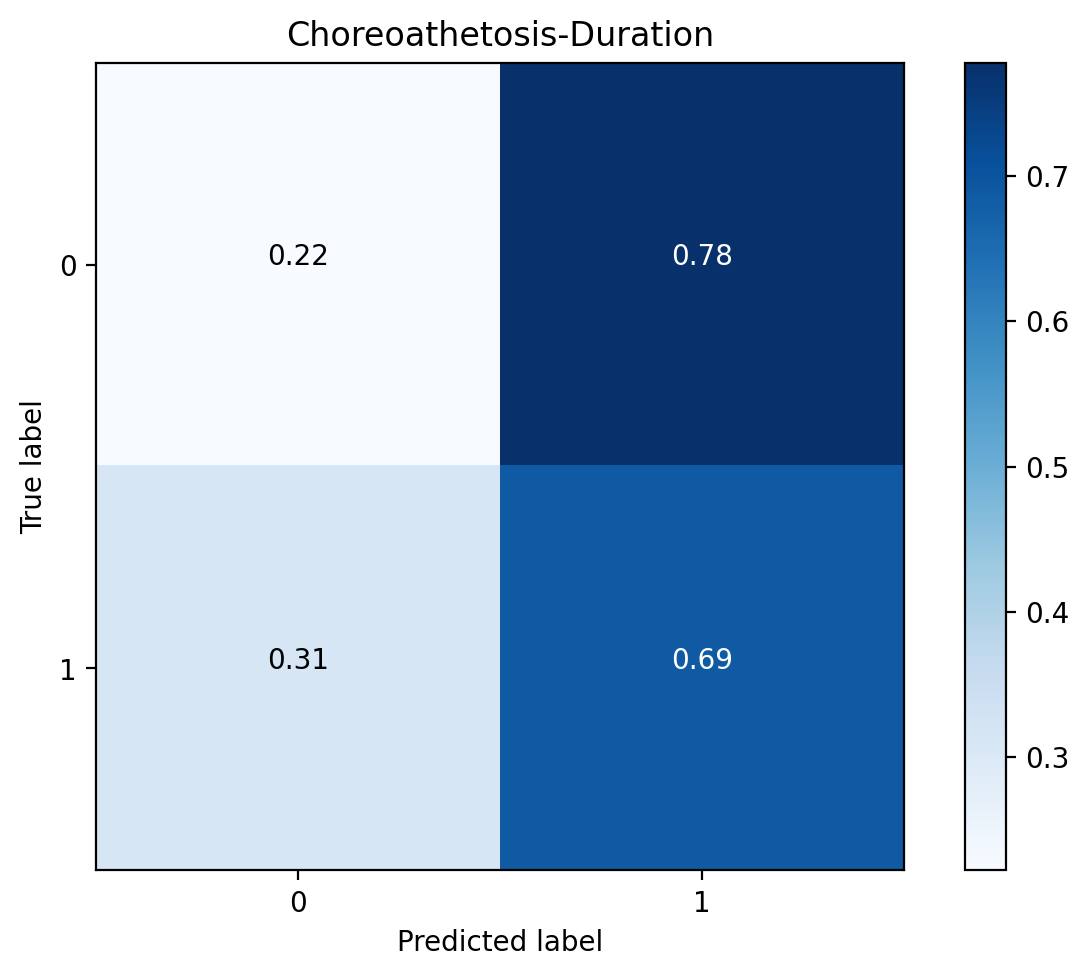

              precision    recall  f1-score   support

           0       0.21      0.22      0.22        18
           1       0.70      0.69      0.69        48

    accuracy                           0.56        66
   macro avg       0.46      0.45      0.46        66
weighted avg       0.57      0.56      0.56        66



In [21]:
Measure = 'Choreoathetosis'

tsc(Measure)